In [1]:
%load_ext autoreload
%autoreload 2
import gymnasium as gym
from pprint import pprint
from torch import nn
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plots

In [2]:
class A2C(nn.Module):
    def __init__(
        self,
        n_features: int,
        n_actions: int,
        device: torch.device,
        critic_lr: float,
        actor_lr: float,
        n_envs: int,
    ) -> None:
        super().__init__()
        self.device = device
        self.n_envs = n_envs

        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(
                32, n_actions
            ),  # estimate action logits (will be fed into a softmax later)
        ]

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = torch.optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = torch.optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.Tensor(x).to(self.device)
        
        state_values = self.critic(x)  # shape: [n_envs,]
        action_logits_vec = self.actor(x)  # shape: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(
        self, x: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(logits=action_logits)  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)

        # Describe this in the report
        entropy = action_pd.entropy()
        return (actions, action_log_probs, state_values, entropy)

    def get_losses(
        self,
        rewards: torch.Tensor,
        action_log_probs: torch.Tensor,
        value_preds: torch.Tensor,
        entropy: torch.Tensor,
        masks: torch.Tensor,
        gamma: float,
        lam: float,
        ent_coef: float,
        device: torch.device,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)

        # compute the advantages using GAE
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = (
                rewards[t] + gamma * masks[t] * value_preds[t + 1] - value_preds[t]
            )
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic
        critic_loss = advantages.pow(2).mean()

        # give a bonus for higher entropy to encourage exploration
        actor_loss = (
            -(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean()
        )
        return (critic_loss, actor_loss)

    def update_parameters(
        self, critic_loss: torch.Tensor, actor_loss: torch.Tensor
    ) -> None:

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [52]:
# environment hyperparams
n_envs = 10
n_updates = 300
n_steps_per_update = 32

# agent hyperparams
gamma = 0.99
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.2  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.0005
critic_lr = 0.0025

envs = gym.vector.make("highway-fast-v0", num_envs=n_envs)

# Need to flatten the observation array since the obs_shape is (5, 5)
obs_shape = envs.single_observation_space.shape
obs_flat_shape = obs_shape[0]**2

action_shape = envs.single_action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init the agent
agent = A2C(obs_flat_shape, action_shape, device, critic_lr, actor_lr, n_envs)

c:\Users\Anway Shirgaonkar\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\vector\__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


In [53]:
# create a wrapper environment to save episode returns and episode lengths
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * n_updates)

critic_losses = []
actor_losses = []
entropies = []

# use tqdm to get a progress bar for training
for sample_phase in tqdm.tqdm(range(n_updates)):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    # at the start of training reset all envs to get an initial state
    if sample_phase == 0:
        states, info = envs_wrapper.reset(seed=42)
        states = np.reshape(states, (n_envs, obs_flat_shape))

    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(states)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs_wrapper.step(actions.cpu().numpy())
        states = np.reshape(states, (n_envs, obs_flat_shape))

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor([not term for term in terminated])

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        lam,
        ent_coef,
        device,
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    if (sample_phase % 500) == 0:
        torch.save(agent.actor.state_dict(), f"actor_weights.h5")
        torch.save(agent.critic.state_dict(), f"critic_weights.h5")

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())

100%|██████████| 300/300 [15:47<00:00,  3.16s/it]


In [12]:
# torch.save(agent.actor.state_dict(), f"actor_weights_8k_1.h5")
# torch.save(agent.critic.state_dict(), f"critic_weights_8k_1.h5")

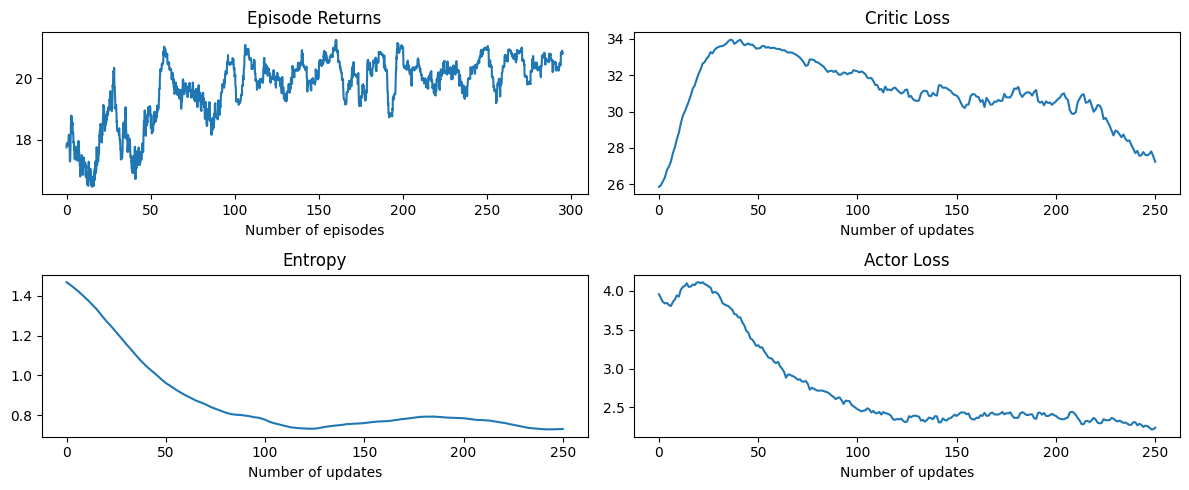

In [55]:
""" plot the results """

# %matplotlib inline

rolling_length = 50
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

In [6]:
agent.actor.load_state_dict(torch.load("actor_weights_8k_1.h5"))
agent.critic.load_state_dict(torch.load("critic_weights_8k_1.h5"))

<All keys matched successfully>

In [56]:
ep = 10
env_render = gym.make("highway-fast-v0", render_mode = "human")
# env_render.config['vehicles_density'] = 1.5
# env_render.config['lanes_count'] = 4
for _ in range(ep):
    state, _ = env_render.reset()
    terminated = False
    truncated = False
    while not (terminated or truncated):
        with torch.no_grad():
                action, _, _, _ = agent.select_action(state.flatten())
                print(action, end='\r')
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        env_render.render()
        state, reward, terminated, truncated, info = env_render.step(action.item())

env_render.close()

In [28]:
env_render.config

c:\Users\Anway Shirgaonkar\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 5,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 3,
 'vehicles_count': 20,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 30,
 'ego_spacing': 1.5,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'normalize_reward': True,
 'offroad_terminal': False}